In [120]:
from __future__ import print_function
import csv
import importlib.util
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import GraphDescriptors
from rdkit.Chem.Descriptors import ExactMolWt
from enum import Enum
import numpy as np
import scipy.stats as stats
import statistics
import math
import string
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 12
plt.rc('text', usetex=True)

In [77]:
cols = ['Barcode','Researcher','Notebook','Page','Smiles','Comments','MW(amu)','MPLOWER','MPUPPER','CardMissing','Notes','LabelNotes']
poster_data = pd.read_csv("MIKI/BurckhalterDatabase.csv", engine='python', names=cols)
new_data = pd.read_csv("BurckhalterDatabase.csv", engine='python', names=cols)
cmld_data = pd.read_csv("MIKI/cmld.csv")

In [224]:
class LibraryError(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

class Library:
    def __init__(self, data):
        self.raw_data = data
        self.smiles = self.smilesToList()
        self.molecules = []
        for entry in self.smiles:
            if entry is not None:
                temp = Chem.MolFromSmiles(entry)
                if temp is not None:
                    self.molecules.append(temp)
        self.molecular_weights = self.getMolecularWeights()
        # self.avgSim, self.fpstdev, self.similarities = self.compareAllFingerprints()
        self.avgComp, self.compstdev, self.complexities = self.getAllComplexities()

    def __filterSmiles():
        return None

    def smilesToList(self):
        smiles_processed = []
        temp = self.raw_data.dropna(subset=['Smiles']).reset_index(drop=True)['Smiles'].to_list()
        # Filter Errors
        for i in temp:
            if ' ' in i.strip(' ') or len(i) == 0: pass
            else: smiles_processed.append(i)
        return smiles_processed

    def compareAllFingerprints(self):
        fprints = [FingerprintMols.FingerprintMol(x) for x in self.molecules]
        fpcompare = []
        for i in range(1, len(fprints)):
            fpcompare.append(DataStructs.FingerprintSimilarity(fprints[0],fprints[i]))
        tempavgSim = 0
        for i in fpcompare:
            tempavgSim += i
        corrected = []
        for i in fpcompare:
            corrected.append(i*100)
        return (tempavgSim/(len(fprints)-1)), statistics.stdev(corrected), corrected

    def getMolecularWeights(self):
        temp = []
        for i in self.molecules:
            temp.append(ExactMolWt(i))
        return temp

    def getAllComplexities(self):
        complexities = []
        for i in self.molecules:
            complexities.append(Chem.GraphDescriptors.BertzCT(i))
        avg = 0
        for i in complexities:
            avg += i/(len(complexities))
        stddev = statistics.stdev(complexities)
        return avg, stddev, complexities

    #def ShowMolecularWeights(self):


    def getFingerprintSimilarityAverage(self):
        x_axis = np.arange(-10, 100, 1)
        plt.plot(x_axis, stats.norm.pdf(x_axis, self.avgSim*100, self.fpstdev))


    def getFingerprintSimilarityHistogram(self, bins=50):
        plt.hist(self.similarities, bins=bins, histtype='barstacked', density=True)

    # Pandas Dataframes
    raw_data = None

    # Lists
    smiles = None
    molecules = None
    molecular_weights = None
    similarities = None
    complexities = None

    # Numbers
    avgSim = None
    fpstdev = None
    avgComp = None
    compstdev = None

class BurckData:
    def __init__(self, poster_data, new_data, cmld_data):

        self.poster_lib = Library(poster_data)
        self.new_lib = Library(new_data)
        self.cmld_lib = Library(cmld_data)

    def getLib(self, lib):
        if lib == 'poster':
            return self.poster_lib
        elif lib == 'burck':
            return self.new_lib
        elif lib == 'cmld':
            return self.cmld_lib
        else:
            raise LibraryError("Could not find library.")

    def getSmiles(self, lib):
        try:
            temp = self.getLib(lib).smiles
            return temp
        except LibraryError:
            print("Got it!")

    def getMolecules(self, lib):
        try:
            temp = self.getLib(lib).molecules
            return temp
        except LibraryError:
            print("Got it!")

    def getNumSmiles(self, lib):
        try:
            temp = self.getLib(lib).smiles
            return len(temp)
        except LibraryError:
            print("Aborting...")

    def getNumMolecules(self, lib):
        try:
            temp = self.getLib(lib).molecules
            return len(temp)
        except LibraryError:
            print("Aborting...")

    def validatedMolToCsv(self, lib):
        """Return a CSV representation of every molecule in the library if and only if RDKIT
        was able to process it."""
        pass

    def getWeightDistribution(self, lib):
        try:
            temp = self.getLib(lib).molecules
            return temp
        except LibraryError:
            pass

    def getSimilarityDistribution(self, lib):
        try:
            temp = self.getLib(lib)
            temp.getFingerprintSimilarityAverage()
            plt.title("Similarity Between Molecule 1 and Others in a " + str(len(temp.molecules)) + "-Member Set")
            plt.xlabel("Similarity Score")
            plt.ylabel("Probability Density")

        except LibraryError:
            pass
        finally:
            print("Aborting...")
            return None

    def getWeightHistogram(self, ):
        try:
            temp = self.getLib(lib)
            plt.hist(temp.molecular_weights, bins=50, histtype='barstacked')
            plt.title("Distribution of Molecular Weights in " + str(len(temp.molecules)) + "-Member Subset")
            plt.xlabel("Molecular Weight (amu)")
            plt.ylabel("Number of Molecules")
        except LibraryError:
            print("Error")


    # Libraries
    poster_lib = None
    new_lib = None
    cmld_lib = None


In [92]:
test = BurckData(poster_data, new_data, cmld_data)

In [87]:
test.getNumSmiles('cmld')

9729

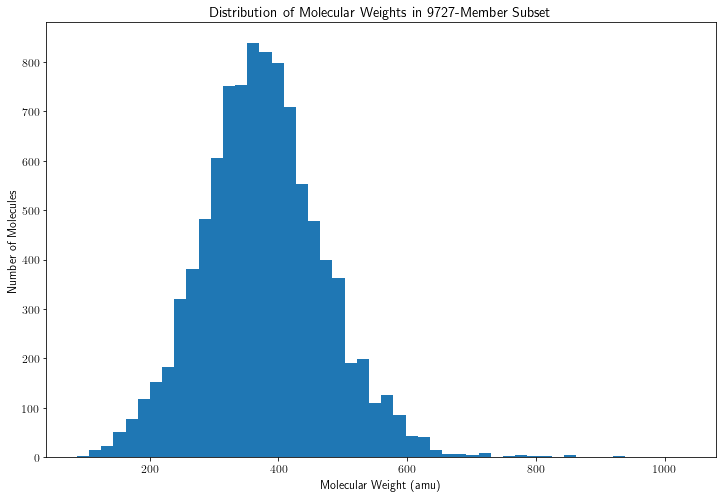

In [97]:
test.getWeightHistogram('cmld')

In [205]:
lines = []
with open('testpidgin.txt', 'r') as f:
    for line in f:
        lines.append(line)

In [209]:
lines[5].replace('\n', '').split('\t')

['Q9NZJ5',
 'Eukaryotic translation initiation factor 2-alpha kinase 3',
 '9451',
 'Kinase',
 'Homo sapiens',
 '4G31 4G34 4M7I',
 'Dehydration | Diabetes Mellitus, Insulin-Dependent | Glycosuria | Congenital Heart Defects | Hepatomegaly | Hyperglycemia | Hyperopia | Orbital separation excessive | Lordosis | Mental Retardation | Multiple Epiphyseal Dysplasia | Muscle Hypertonia | Muscle hypotonia | Osteopenia | Osteoporosis | Kidney Failure | Reperfusion Injury | Status Epilepticus | Steatorrhea | Progressive supranuclear palsy | Liver Dysfunction | Myocardial Ischemia | Renal tubular disorder | Liver function tests abnormal finding | Congenital heart disease | Liver Failure, Acute | Ketoacidosis | Brachydactyly | Hepatic enzyme increased | Coxa valga | High forehead | Microdontia (disorder) | Byzanthine arch palate | Barrel chest | Preauricular dimple | Preauricular sinus | Transient neonatal diabetes mellitus | Short stature | Epiphyseal dysplasia | Upward slant of palpebral fissure |

In [210]:
for index, line in enumerate(lines):
    lines[index] = line.replace('\n', '').split('\t')

In [211]:
lines[5]

['Q9NZJ5',
 'Eukaryotic translation initiation factor 2-alpha kinase 3',
 '9451',
 'Kinase',
 'Homo sapiens',
 '4G31 4G34 4M7I',
 'Dehydration | Diabetes Mellitus, Insulin-Dependent | Glycosuria | Congenital Heart Defects | Hepatomegaly | Hyperglycemia | Hyperopia | Orbital separation excessive | Lordosis | Mental Retardation | Multiple Epiphyseal Dysplasia | Muscle Hypertonia | Muscle hypotonia | Osteopenia | Osteoporosis | Kidney Failure | Reperfusion Injury | Status Epilepticus | Steatorrhea | Progressive supranuclear palsy | Liver Dysfunction | Myocardial Ischemia | Renal tubular disorder | Liver function tests abnormal finding | Congenital heart disease | Liver Failure, Acute | Ketoacidosis | Brachydactyly | Hepatic enzyme increased | Coxa valga | High forehead | Microdontia (disorder) | Byzanthine arch palate | Barrel chest | Preauricular dimple | Preauricular sinus | Transient neonatal diabetes mellitus | Short stature | Epiphyseal dysplasia | Upward slant of palpebral fissure |

In [212]:
for index, line in enumerate(lines):
    if len(line) > 21:
        print(index)

In [222]:
test = pd.DataFrame(lines)
test.rename(columns=test.iloc[0]).drop(test.index[0])

,Uniprot,Name,Gene_ID,Protein_Classification,Organism,PDB_IDs,DisGeNET_0.06,ChEMBL_First_Publication,Activity_Threshold,Actives,Orthologue_Actives,Inactives,Orthologue_Inactives,Sphere_Exclusion_Inactives,Ratio,Model_ID,Compound0,Compound1,Compound2,Compound3
1,P35030,Trypsin III,5646,Protease,Homo sapiens,1H4W 2R9P 3L33 3L3T 3P92 3P95 4DG4 4U30 4U32,Bladder Neoplasm,1978,1,226,0,79,0,2181,10.0,"P35030,SE_1",nan,nan,nan,nan
2,Q13946,Phosphodiesterase 7A,5150,Hydrolases,Homo sapiens,1ZKL 3G3N 4PM0,N/A,1995,0.1,340,0,2,0,3398,10.0,"Q13946,SE_0.1",nan,nan,nan,nan
3,P39900,Matrix metalloproteinase 12,4321,Protease,Homo sapiens,1JIZ 1JK3 1OS2 1OS9 1RMZ 1ROS 1UTT 1UTZ 1Y93 1...,Spontaneous abortion | Rheumatoid Arthritis | ...,2000,1,364,0,6,0,3634,10.0,"P39900,SE_1",nan,nan,nan,nan
4,Q8N1Q1,Carbonic anhydrase XIII,377677,Lyases,Homo sapiens,3CZV 3D0N 3DA2 4HU1 4KNM 4KNN,N/A,2010,0.1,87,0,23,0,977,11.5,"Q8N1Q1,SE_0.1",nan,nan,0.0,nan
5,Q9NZJ5,Eukaryotic translation initiation factor 2-alp...,9451,Kinase,Homo sapiens,4G31 4G34 4M7I,"Dehydration | Diabetes Mellitus, Insulin-Depen...",N/A,1,78,0,1000,0,0,12.8,Q9NZJ5_1,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,P21730,C5a anaphylatoxin chemotactic receptor,728,GPCR,Homo sapiens,N/A,"Liver Cirrhosis, Experimental | Obesity | Sept...",1991,1,266,0,53,0,2607,10.0,"P21730,SE_1",nan,nan,nan,nan
2397,O43497,Voltage-gated T-type calcium channel alpha-1G ...,8913,Ion_Channel,Homo sapiens,N/A,Intellectual Disability | SPINOCEREBELLAR ATAX...,2004,0.1,70,0,49,0,951,14.3,"O43497,SE_0.1",nan,nan,nan,nan
2398,P53609,Geranylgeranyl transferase type I beta subunit,5229,Transferases,Homo sapiens,N/A,N/A,1994,0.1,91,0,5,0,995,11.0,"P53609,SE_0.1",nan,nan,nan,nan
2399,Q14534,Squalene monooxygenase,6713,Oxidoreductases,Homo sapiens,N/A,"Liver Neoplasms, Experimental",1989,1,22,0,0,0,1000,45.5,"Q14534,SE_1",nan,nan,nan,nan
